In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import numpy as np
import scipy.io as sio
import sklearn as sk

from sklearn import decomposition
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

import pickle
import os
import pprint as pp

from dtw import dtw
from cdtw import pydtw

from tqdm import tqdm # progress bar

In [4]:
import cyclingrnn.geometric as geo
from cyclingrnn import sigerr
from cyclingrnn.train import *

In [132]:
# sns colormaps
cmap = sns.color_palette('RdBu',5)[:2] + sns.color_palette('RdBu',5)[-2:]
sns.set_palette(cmap)
sns.set_context('paper', font_scale=1.5)

In [8]:
def giant_regplot(df, cols=None, rows=None, logs=[]):

  if not cols:
    cols = df.columns
    for col in cols:
      try:
        if len(df[col].unique())==1: # this returns an error when df[col] is an e.g. list
          df = df.drop(col, axis=1) # drop columns with all identical entries
      except:
        df = df.drop(col, axis=1) # if above returned an error, drop
    cols = df.columns # now we have our column set
  if not rows:
    rows = df.columns
  
  isnumeric_col = [np.any([isinstance(i, (int, long, float, complex)) for i in df[c]]) for c in cols]  
  isnumeric_row = [np.any([isinstance(i, (int, long, float, complex)) for i in df[r]]) for r in rows]  
  
  fact = 3
  num_cols, num_rows = len(cols), len(rows)
  f, ax = plt.subplots(num_rows, num_cols, figsize=(fact*num_cols, fact*num_rows), sharey=False, sharex=False)
  for ir, row in enumerate(rows):
    for ic, col,  in enumerate(cols):
      logx_bool = col in logs
      if logx_bool:
        ax[ir, ic].set_xscale('log', basex=10)
      logy_bool = row in logs
      if logy_bool:
        ax[ir, ic].set_yscale('log', basex=10)

      if np.logical_xor(isnumeric_row[ir], isnumeric_col[ic]):
        sns.violinplot(x=col, y=row, data=df, ax=ax[ir, ic])
      elif (isnumeric_row[ir] and isnumeric_col[ic]):
        sns.regplot(col, row, df, logx=logx_bool, ax=ax[ir, ic], truncate=False)
        #ax[ir, ic].scatter(df[col], df[row], c=df['activation']=='tanh')
        d_range = df[row].max() - df[row].min()
        ax[ir, ic].set_ylim([df[row].min()-0.1*d_range, df[row].max()+0.1*d_range])
        ax[ir, ic].set_xlim([df[col].min(), df[col].max()])
        
        try:
          ax[ir, ic].axhline(m1_metrics[row], color='k')
        except:
          pass

      if ir < num_rows-1:
        ax[ir, ic].xaxis.label.set_visible(False)
      if ic > 0:
        ax[ir, ic].yaxis.label.set_visible(False)
        
  return f, ax


In [10]:
def evaluate_run(conds, monkey):
  # Get monkey
  # build input and output data
  if monkey == 'D':
    try:
      data = sio.loadmat('./drakeFeb_processed.mat') #TODO: fix, '../' or './' depending on whether running from wrapper or not
    except:
      data = sio.loadmat('../drakeFeb_processed.mat')
  elif monkey == 'C':
    try:
      data = sio.loadmat('./cousFeb_processed.mat')
    except:
      data = sio.loadmat('../cousFeb_processed.mat')
  
  emg = data['EMG']
  m1 = data['M1']

  m1_ = m1[:, conds, :]
  emg_ = emg[:, conds, :]


  mets = dict()
  R2 = 1.

  mets['sim_num'] = 0

  mets['percent_tangling1_01']  = geo.percent_tangling( m1_, emg_, th=1, alpha=0.1 ) # note condition truncation on emg
  mets['percent_tangling2_01']  = geo.percent_tangling( m1_, emg_, th=2, alpha=0.1 ) # note condition truncation on emg
  mets['percent_tangling3_01']  = geo.percent_tangling( m1_, emg_, th=3, alpha=0.1 ) # note condition truncation on emg
  mets['percent_tangling1_001'] = geo.percent_tangling( m1_, emg_, th=1, alpha=0.01 ) # note condition truncation on emg
  mets['percent_tangling2_001'] = geo.percent_tangling( m1_, emg_, th=2, alpha=0.01 ) # note condition truncation on emg
  mets['percent_tangling3_001'] = geo.percent_tangling( m1_, emg_, th=3, alpha=0.01 ) # note condition truncation on emg

  mets['tangling_90_01']  = geo.tangling_cdf( m1_, cutoff=0.90, alpha=0.1  )
  mets['tangling_90_001'] = geo.tangling_cdf( m1_, cutoff=0.90, alpha=0.01 )
  mets['tangling_95_01']  = geo.tangling_cdf( m1_, cutoff=0.95, alpha=0.1  )
  mets['tangling_95_001'] = geo.tangling_cdf( m1_, cutoff=0.95, alpha=0.01 )

  mets['path_length'] = np.sum(geo.get_path_length(m1_, filt_freq=0.25))
  mets['mean_curvature'], mets['mean_torsion'], _ = geo.mean_curvature(m1_, total_points=11, deg=4, normalize=True)
  
  mets['MSE'] = 0.
  mets['R2'] = R2

  mets['noise_robustness'], mets['struct_robustness'] = 0., 0.
    
  return mets


In [11]:
df_path = '../saves/170220D/df0123.pickle'
df = pickle.load(open(df_path))
m1_metrics = evaluate_run([0,1,2,3], 'D')

In [ ]:
df = df[df.activation == 'tanh']

In [12]:
cols = ['beta1', 'beta2', 'stddev_state', 'learning_rate', 'rnn_init', 'activation']
rows = ['R2', 'MSE','tangling_95_01','tangling_95_001', 'tangling_90_01', 'tangling_90_001', 'struct_robustness','noise_robustness', 'mean_curvature', 'mean_torsion']
logs = ['beta1', 'beta2', 'stddev_state', 'learning_rate', 'noise_robustness', 'struct_robustness']

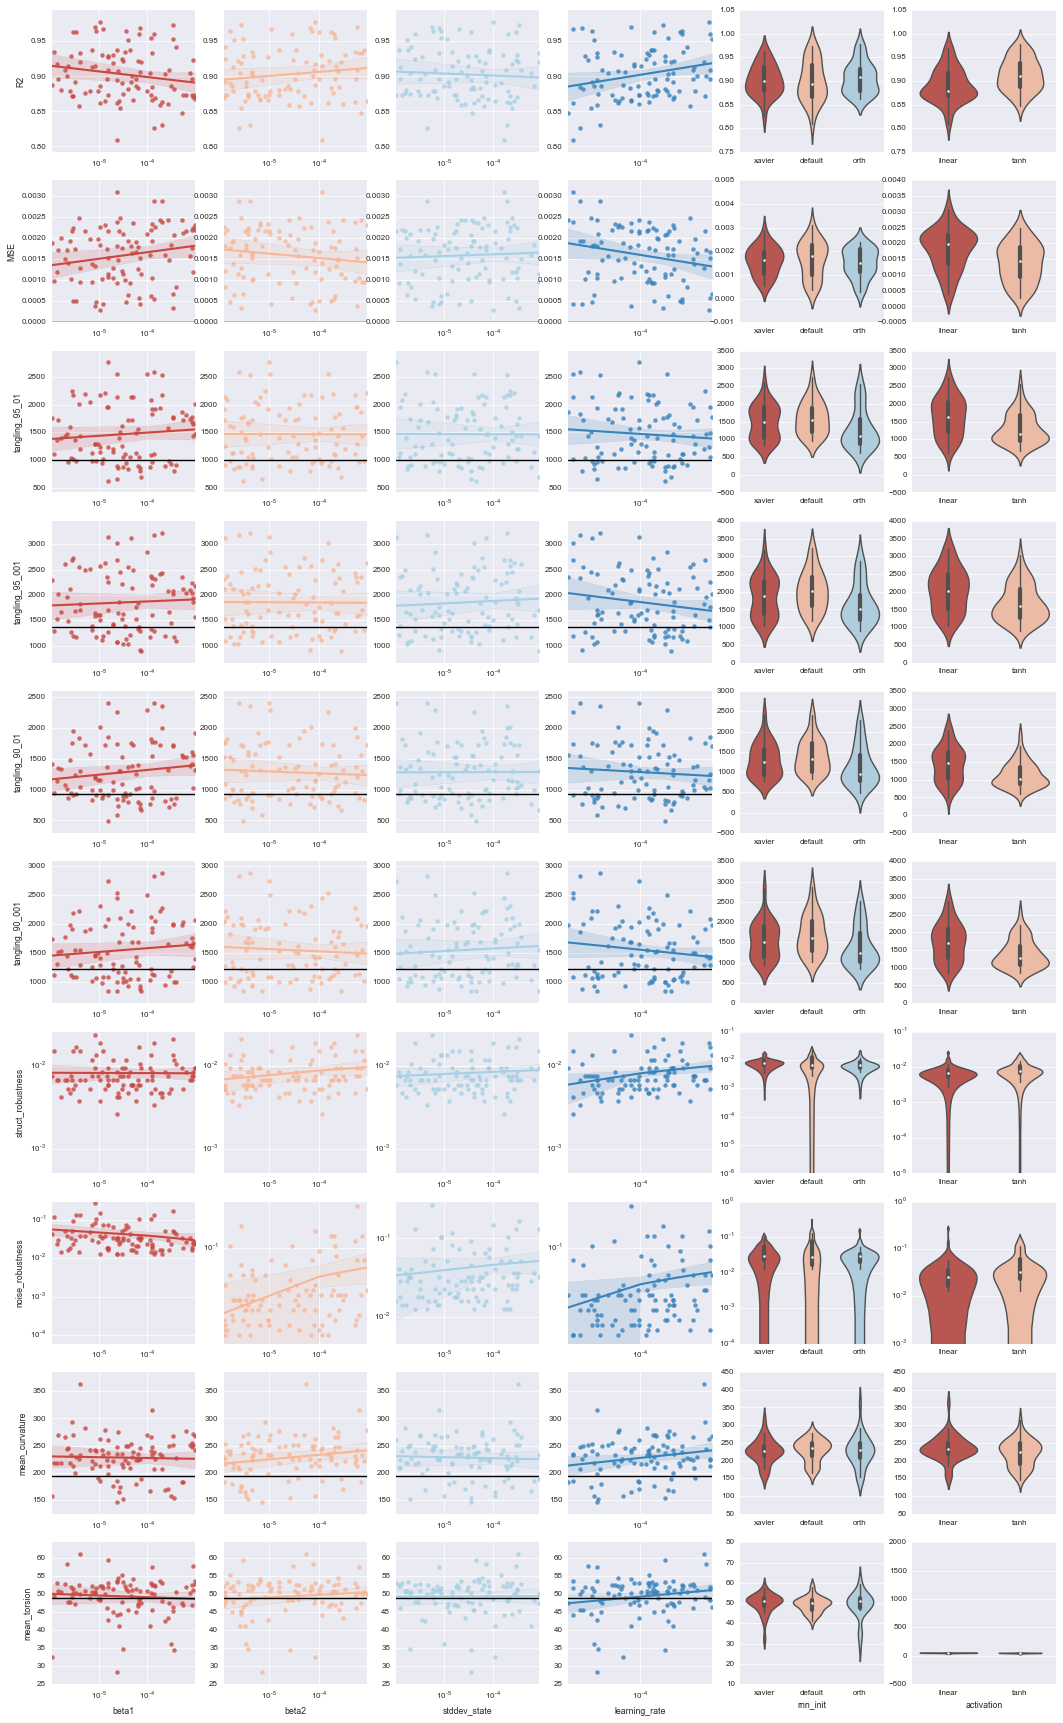

In [13]:
f, ax = giant_regplot(df, cols, rows, logs)

In [14]:
# pick good RNNs
i1 = df.activation == 'tanh'
i2 = df.tangling_95_01 < m1_metrics['tangling_95_01'] + 200# and df.tangling_95_01 > (m1_metrics['tangling_95_01'] - 300)
i3 = df.tangling_95_01 > m1_metrics['tangling_95_01'] - 200

i4 = df.mean_curvature < m1_metrics['mean_curvature'] + 50# and df.tangling_95_01 > (m1_metrics['tangling_95_01'] - 300)
i5 = df.mean_curvature > m1_metrics['mean_curvature'] - 50

In [15]:
df_ = df[i1 & i2 & i3 & i4 & i5]

In [16]:
df_.sim_num

8      7.0
12    33.0
14    48.0
18    76.0
19    84.0
20    91.0
34    28.0
37    49.0
38    57.0
40    71.0
52    68.0
54    90.0
70    27.0
71    34.0
77    92.0
78    99.0
79    17.0
87    75.0
Name: sim_num, dtype: float64

In [ ]:
import sklearn as sk

In [143]:
# m1 data
data = sio.loadmat('../drakeFeb_processed.mat')
m1 = data['M1']
emg = data['EMG']

In [73]:
x = np.load('../saves/170220D/npsaves/99x.npy')

In [74]:
x = x[:m1.shape[0], :m1.shape[1], :]

In [165]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf')

In [166]:
def make_pairgrid(d):
  """
    sns.PairGrid plotter for cycling data
    in: (d1,d2,d3,d4)
  """
  df = pd.DataFrame(np.concatenate(d))
  colnames = {}
  for i in range(d[0].shape[1]):
    colnames[i] = 'PC '+str(i+1)
  df = df.rename(columns=colnames)
  
  cond_labels = d[0].shape[0]*['forward, top'] + d[1].shape[0]*['forward, bottom'] + d[2].shape[0]*['backward, top'] + d[3].shape[0]*['backward, bottom']
  df['condition'] = cond_labels
  g = sns.PairGrid(df, hue='condition', diag_sharey=True)
  #g.map_diag(plt.hist)
  g.map_diag(sns.kdeplot, lw=3, legend=False)
  g.map_offdiag(plt.plot)
  #g.add_legend()
  return g

In [167]:
pca_x = sk.decomposition.PCA(n_components=4)
pca_x.fit(np.concatenate([x[:,i,:] for i in range(4)]))
f = make_pairgrid([np.dot(x[:,i,:], pca_x.components_.T) for i in range(4)])
f.fig.suptitle('RNN')

In [168]:
pca_x = sk.decomposition.PCA(n_components=4)
pca_x.fit(np.concatenate([m1[:,i,:] for i in range(4)]))
f = make_pairgrid([np.dot(m1[:,i,:], pca_x.components_.T) for i in range(4)])
f.fig.suptitle('Motor cortex, monkey D')

In [169]:
pca_x = sk.decomposition.PCA(n_components=4)
pca_x.fit(np.concatenate([emg[:,i,:] for i in range(4)]))
f = make_pairgrid([np.dot(emg[:,i,:], pca_x.components_.T) for i in range(4)])
f.fig.suptitle('EMG, monkey D')